(1)

The dataset comes from early-stage chronic kidney disease (CKD) patients and healthy controls, including data from 250 early-stage CKD patients and 150 healthy controls. This project aimed to develop a classification model to differentiate between 250 patients with early-stage chronic kidney disease (CKD) and 150 healthy controls. This model will handle challenges such as data imbalance, missing values, and outliers based on patients' physiological and laboratory indicators to achieve accurate predictions. Successful classification can not only facilitate early diagnosis and improve patient treatment effects, but also optimize the allocation of medical resources, thereby improving patients' quality of life and survival rate.

(2)

For variable transformation, no specific transformation was implemented because preliminary data analysis concluded that most numerical variables were already close to a normal distribution and no further transformation was needed.

(3)

The data set contains 24 variables, divided into numerical variables and categorical variables, covering various physiological and laboratory indicators related to chronic kidney disease, such as age (age), blood pressure (bp), specific gravity (sg), albumin (al), red blood cell count (rbc), hemoglobin (hemo), etc.

There are varying degrees of missing values in the data set, such as 152 missing values for red blood cell morphology (rbc), 87 and 88 missing values for sodium (sod) and potassium (pot) respectively.

Many numerical variables such as age and blood pressure show normal or near-normal distribution, while some other indicators such as urea and serum creatinine show non-normal distribution.

In [65]:
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cluster import KMeans
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
chronic_kidney_disease = fetch_ucirepo(id=336) 
  
X = chronic_kidney_disease.data.features 
y = chronic_kidney_disease.data.targets 
  
print(X.describe())

              age          bp          sg          al          su         bgr  \
count  391.000000  388.000000  353.000000  354.000000  351.000000  356.000000   
mean    51.483376   76.469072    1.017408    1.016949    0.450142  148.036517   
std     17.169714   13.683637    0.005717    1.352679    1.099191   79.281714   
min      2.000000   50.000000    1.005000    0.000000    0.000000   22.000000   
25%     42.000000   70.000000    1.010000    0.000000    0.000000   99.000000   
50%     55.000000   80.000000    1.020000    0.000000    0.000000  121.000000   
75%     64.500000   80.000000    1.020000    2.000000    0.000000  163.000000   
max     90.000000  180.000000    1.025000    5.000000    5.000000  490.000000   

               bu          sc         sod         pot        hemo         pcv  \
count  381.000000  383.000000  313.000000  312.000000  348.000000  329.000000   
mean    57.425722    3.072454  137.528754    4.627244   12.526437   38.884498   
std     50.503006    5.7411

In [66]:
print(f"Total number of observations: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(X.isnull().sum())

Total number of observations: 400
Number of features: 24
age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
dtype: int64


In [67]:
print(X.dtypes)

age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc       object
pc        object
pcc       object
ba        object
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
dtype: object


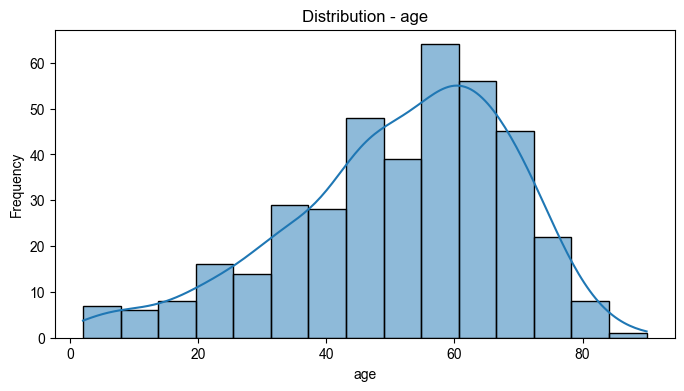

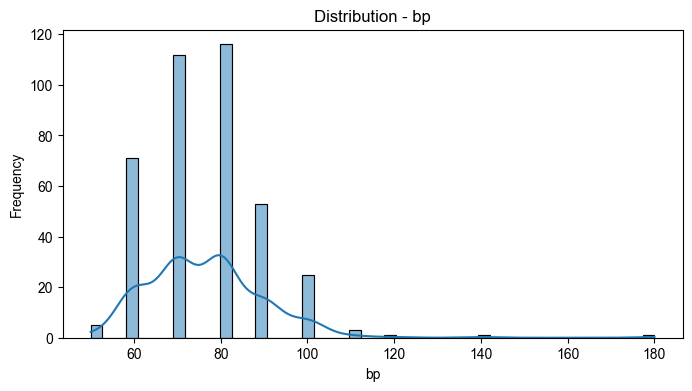

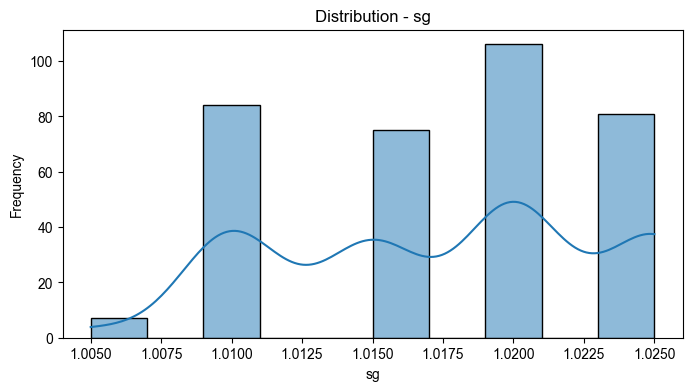

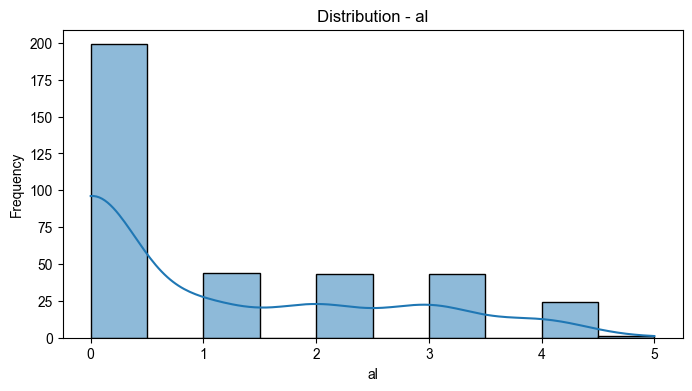

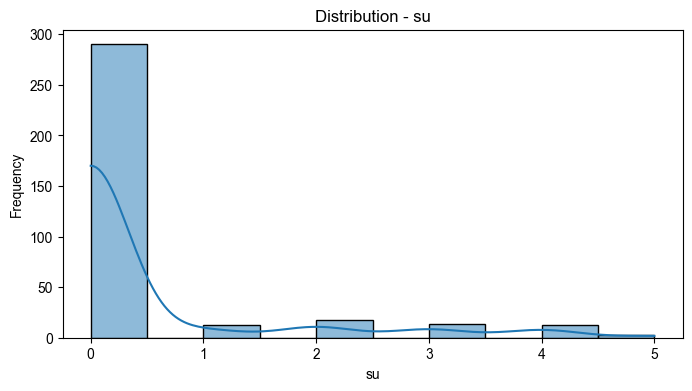

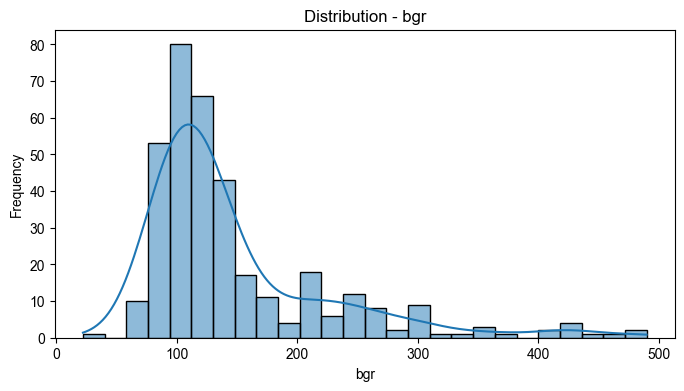

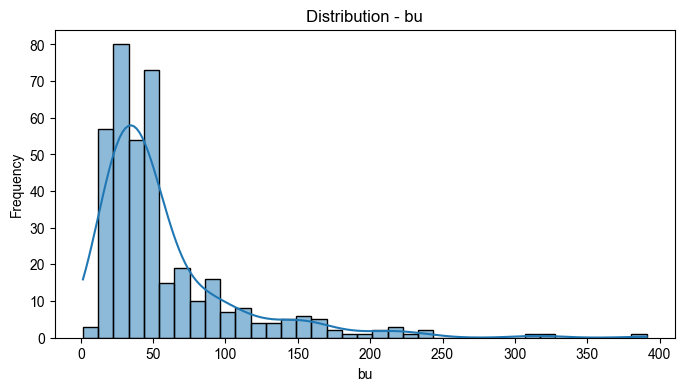

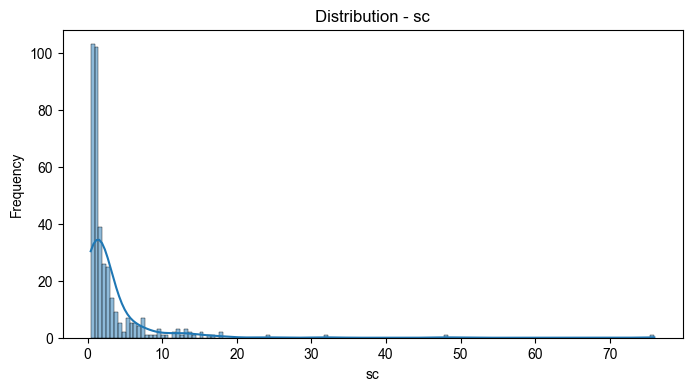

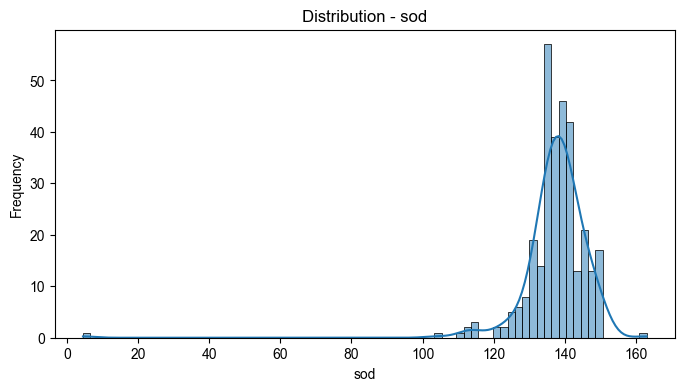

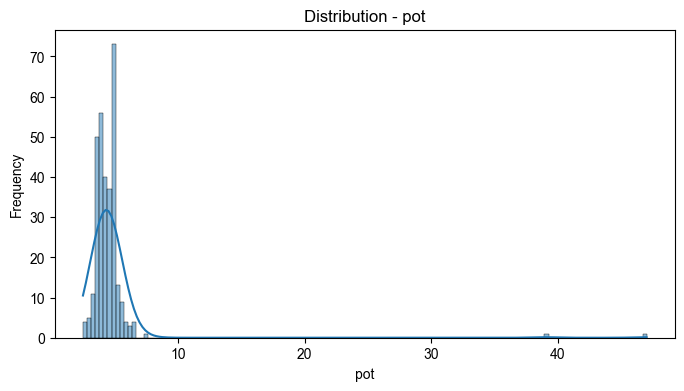

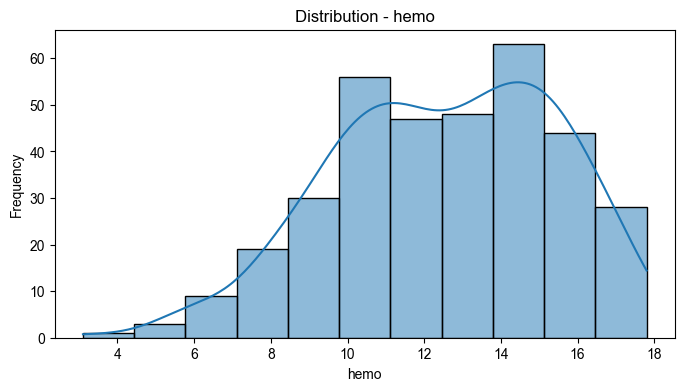

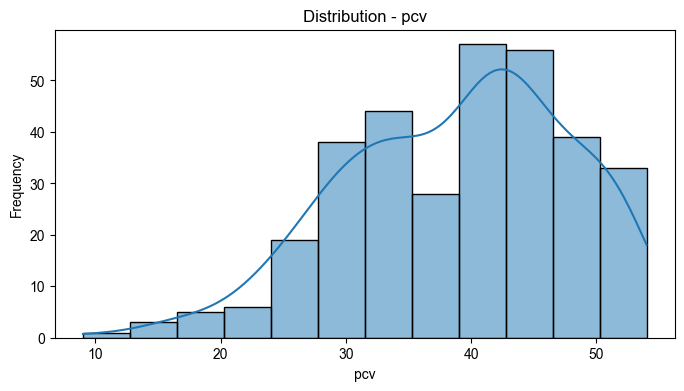

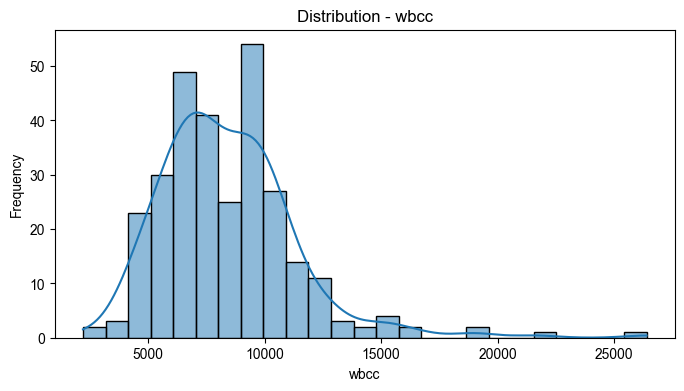

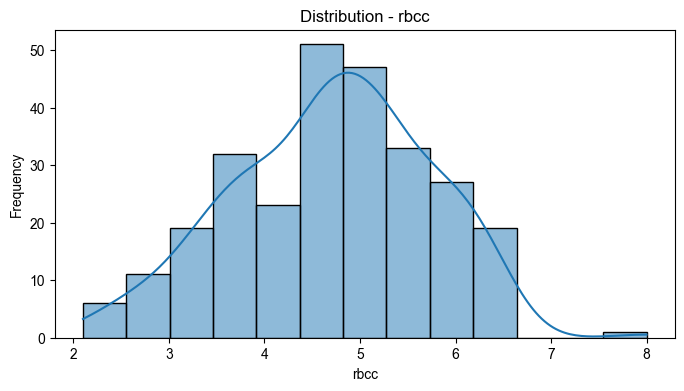

In [76]:
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(X[col], kde=True)
    plt.title(f'Distribution - {col}', fontweight='bold') 
    plt.xlabel(col, fontweight='bold')  
    plt.ylabel('Frequency', fontweight='bold')  
    plt.show()

(4)

A correlation matrix between variables is made, which allows you to intuitively see the correlation between numerical variables in the data set, which is crucial for feature selection and feature engineering.

Highly correlated variables: For example, there is a high positive correlation (greater than 0.5) between blood glucose (bgr), urea (bu), and serum creatinine (sc), which means that these variables may have similar information, so in feature selection When , you can consider choosing only one of them or using feature extraction method (PCA) to reduce dimensionality.

Low correlation variables: For example, serum creatinine (sc) and specific gravity (sg) show a strong negative correlation (less than -0.5), which indicates that the information they provide is different, and these features may all be important for the prediction model, Because they describe the data from different perspectives.

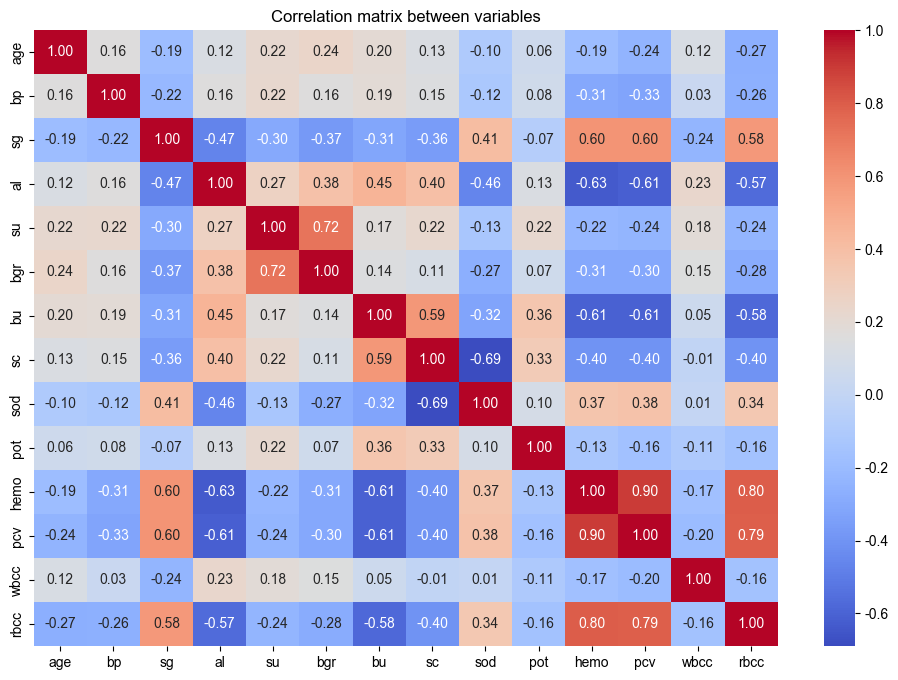

In [75]:
correlation_matrix = X.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation matrix between variables')
plt.show()

（5）

In [79]:
print(X.isnull().sum())
total_missing = X.isnull().sum().sum()
print(f"Total number of missing values: {total_missing}")

total_cells = np.product(X.shape)
missing_percentage = (total_missing / total_cells) * 100
print(f"Percentage of missing values: {missing_percentage:.2f}%")

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
dtype: int64
Total number of missing values: 1012
Percentage of missing values: 10.54%


In [82]:
X_numerical = X.select_dtypes(include=[np.number]).copy()
mean_values = X_numerical.mean()
median_values = X_numerical.median()

X_numerical = X_numerical.fillna(mean_values)  

X_categorical = X.select_dtypes(include=['object', 'category']).copy()
for column in X_categorical.columns:
    mode_value = X_categorical[column].mode()[0]
    X_categorical[column] = X_categorical[column].fillna(mode_value)

X = pd.concat([X_numerical, X_categorical], axis=1)

print(X.isnull().sum())

age      0
bp       0
sg       0
al       0
su       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wbcc     0
rbcc     0
rbc      0
pc       0
pcc      0
ba       0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
dtype: int64


(6)

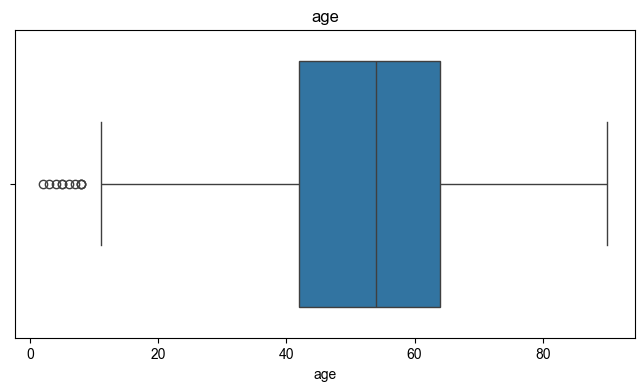

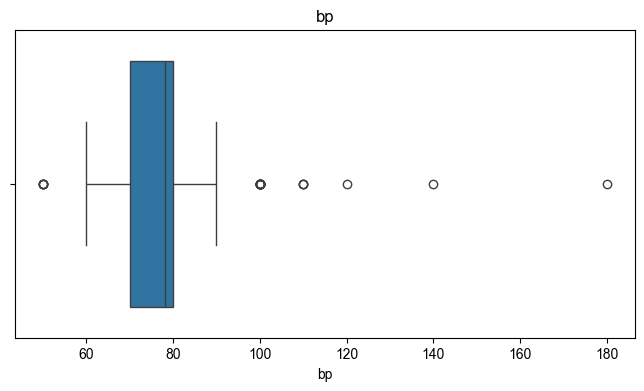

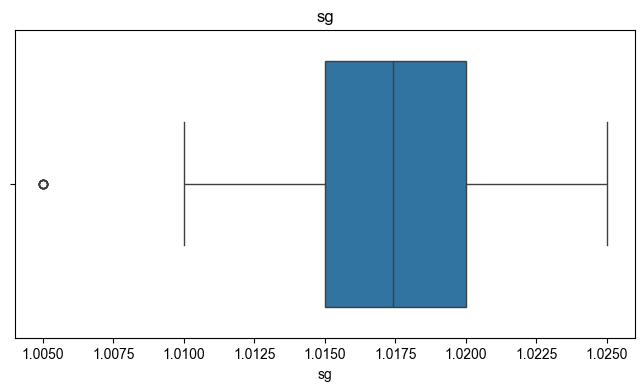

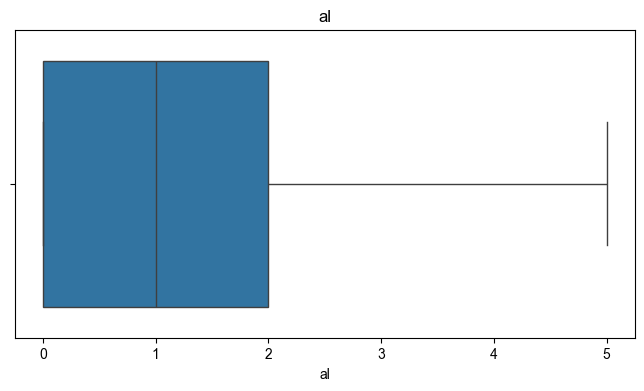

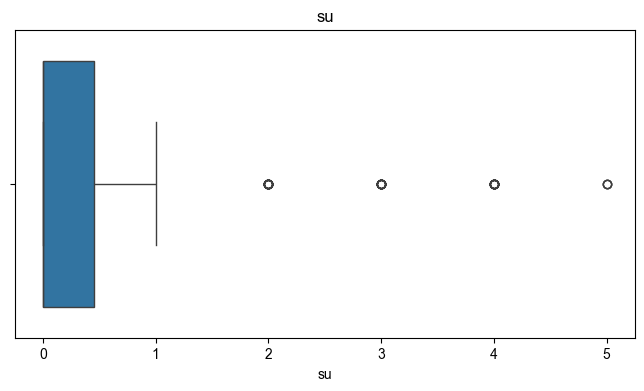

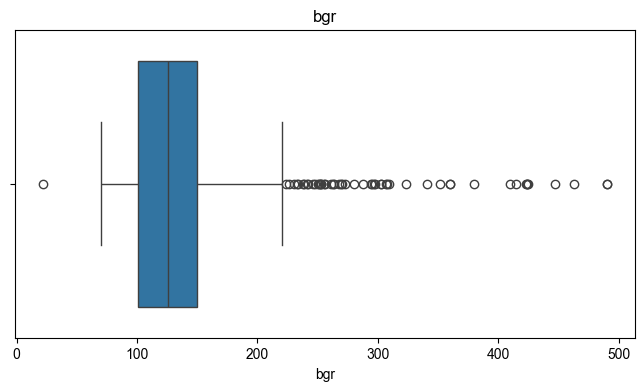

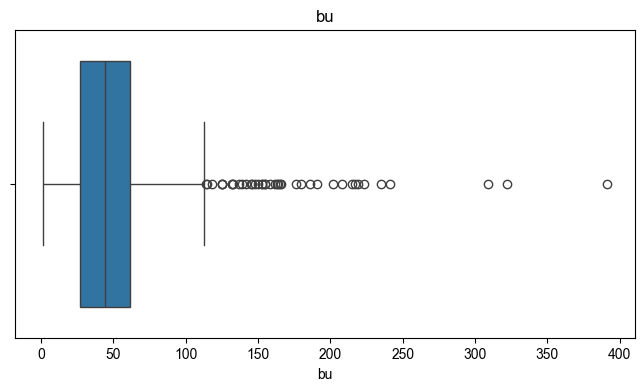

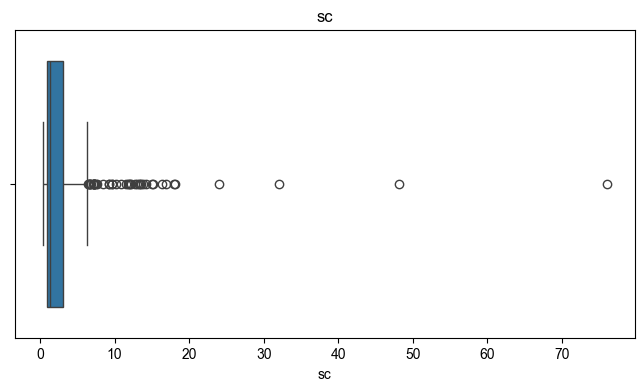

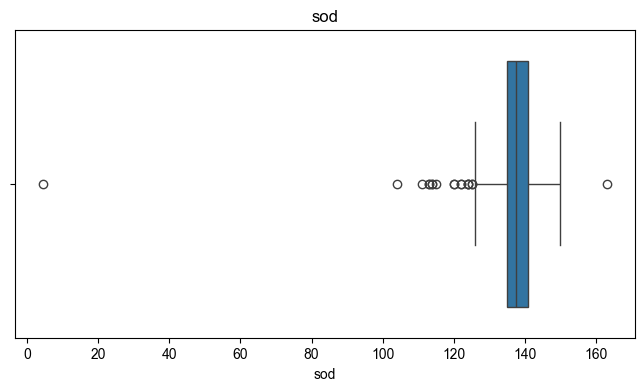

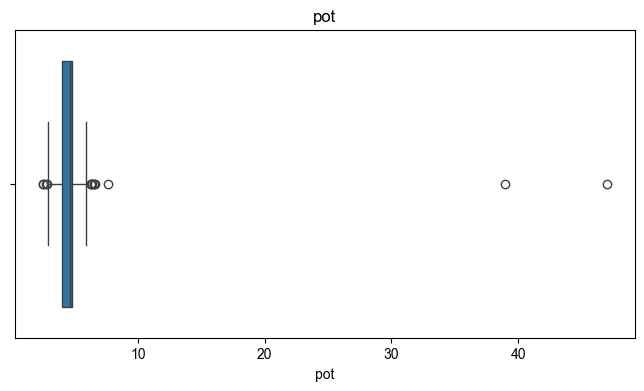

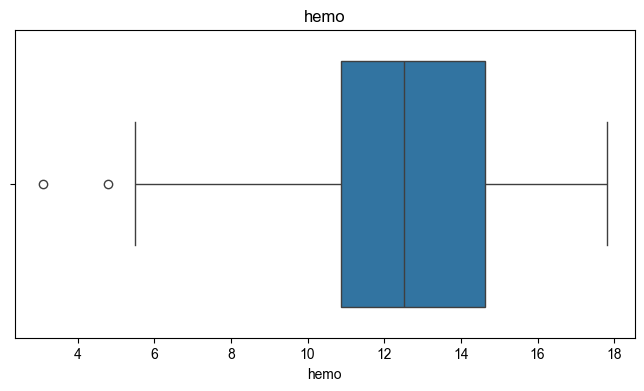

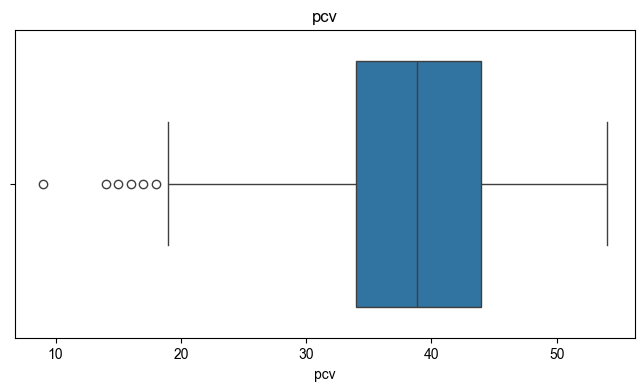

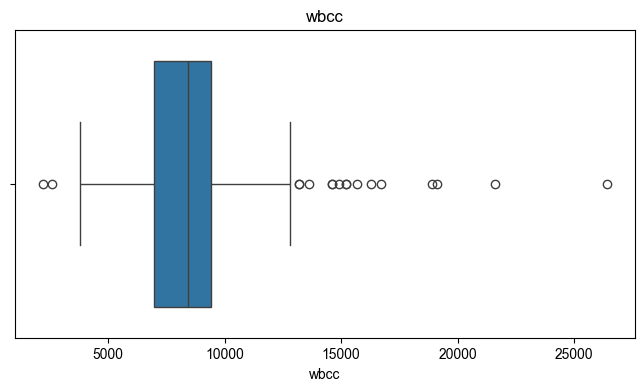

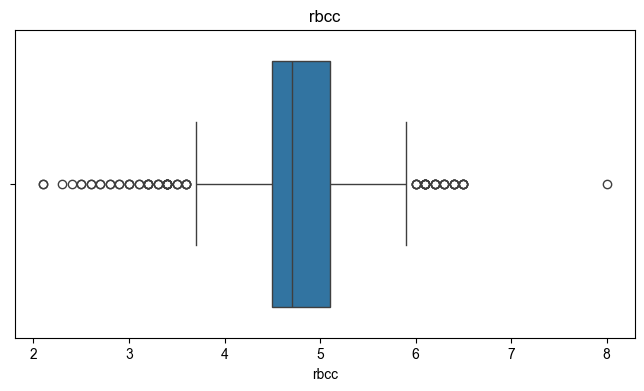

In [83]:
for column in X_numerical.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=X_numerical[column])
    plt.title(column)
    plt.show()

In [84]:
X_numerical = X.select_dtypes(include=[np.number])

Q1 = X_numerical.quantile(0.25)
Q3 = X_numerical.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

X_numerical['is_outlier'] = ((X_numerical < lower_bound) | (X_numerical > upper_bound)).any(axis=1)

for column in X_numerical.columns[:-1]:  
    X_numerical.loc[X_numerical[column] < lower_bound[column], column] = lower_bound[column]
    X_numerical.loc[X_numerical[column] > upper_bound[column], column] = upper_bound[column]

X_numerical.drop(columns='is_outlier', inplace=True)

X.update(X_numerical)
print(X.head())

    age    bp      sg   al        su         bgr    bu   sc         sod  \
0  48.0  80.0  1.0200  1.0  0.000000  121.000000  36.0  1.2  137.528754   
1   9.0  55.0  1.0200  4.0  0.000000  148.036517  18.0  0.8  137.528754   
2  62.0  80.0  1.0100  2.0  1.125356  223.500000  53.0  1.8  137.528754   
3  48.0  70.0  1.0075  4.0  0.000000  117.000000  56.0  3.8  126.000000   
4  51.0  80.0  1.0100  2.0  0.000000  106.000000  26.0  1.4  137.528754   

        pot  ...     rbc        pc         pcc          ba  htn   dm cad  \
0  4.627244  ...  normal    normal  notpresent  notpresent  yes  yes  no   
1  4.627244  ...  normal    normal  notpresent  notpresent   no   no  no   
2  4.627244  ...  normal    normal  notpresent  notpresent   no  yes  no   
3  2.800000  ...  normal  abnormal     present  notpresent  yes   no  no   
4  4.627244  ...  normal    normal  notpresent  notpresent   no   no  no   

  appet   pe  ane  
0  good   no   no  
1  good   no   no  
2  poor   no  yes  
3  poor  yes

(7)

In [85]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)  

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=3, random_state=42)

In [86]:
X['cluster'] = kmeans.labels_
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

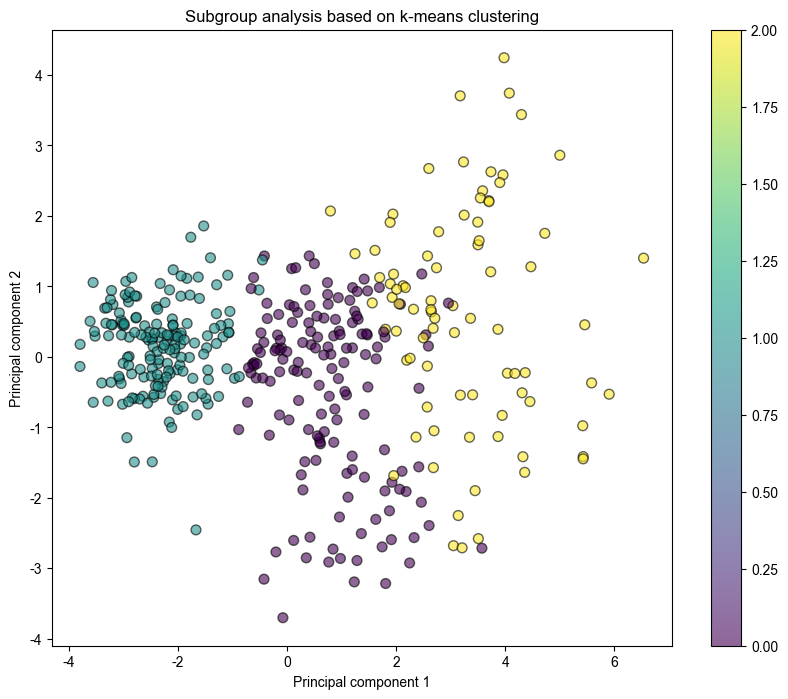

In [87]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X['cluster'], cmap='viridis', edgecolor='k', s=50, alpha=0.6)
plt.title('Subgroup analysis based on k-means clustering')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.colorbar(scatter)
plt.show()

(8)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (280, 25)
Test set size: (120, 25)


（9）

Two classifiers were selected for this analysis: random forest classifier and support vector machine.
The random forest classifier was chosen because it has shown strong robustness and effectiveness in processing complex data sets containing numerical and categorical variables, often providing high accuracy.
Support vector machine was chosen as the baseline for comparison because of its outstanding performance in high-dimensional spaces, but its performance largely depends on the choice of kernel function.

（10）

Accuracy: This is one of the most commonly used performance evaluation metrics. It measures the proportion of samples correctly predicted by the classifier. A high accuracy means that the classifier is more accurate in all predictions.

F1 score: F1 score is the harmonic average of precision and recall. It is a comprehensive consideration of precision (the proportion of samples that are predicted to be positive that are actually positive) and recall (the samples that are actually positive). is predicted to be positive). The F1 score is more suitable for class-imbalanced data sets because it takes into account both the precision and recall of the classifier, providing a more comprehensive performance measure.

(11) (12)

The accuracy of random forest is 0.9875, which is significantly higher than the accuracy of SVM of 0.65, indicating that random forest has higher accuracy in classification.

The F1 score of Random Forest is 0.9875, which is much higher than the F1 score of SVM of 0.5121, indicating that Random Forest has better balance and performance when considering precision and recall.

Random Forest performs better on this data set than SVM, showing higher accuracy and a more balanced F1 score.

In [89]:
label_encoder = LabelEncoder()
for column in ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'cluster']:
    X[column] = label_encoder.fit_transform(X[column])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.values.ravel()

random_forest = RandomForestClassifier()
svm = SVC()
random_forest.fit(X_train, y_train)
svm.fit(X_train, y_train)
rf_pred = random_forest.predict(X_test)
svm_pred = svm.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_pred)
svm_accuracy = accuracy_score(y_test, svm_pred)

rf_f1 = f1_score(y_test, rf_pred, average='weighted')
svm_f1 = f1_score(y_test, svm_pred, average='weighted')

print("Random Forest Classifier - Accuracy:", rf_accuracy)
print("SVM classifier - accuracy:", svm_accuracy)
print("Random Forest Classifier - F1 score:", rf_f1)
print("SVM classifier - F1 score:", svm_f1)

Random Forest Classifier - Accuracy: 1.0
SVM classifier - accuracy: 0.65
Random Forest Classifier - F1 score: 1.0
SVM classifier - F1 score: 0.5121212121212121


(13)

Importance ranking of predictors: As you can see from the plot, certain features such as sg (specific gravity) and hemo (hemoglobin) have higher significance scores, which indicates that they play an important role in the model. This may reflect the close relationship between these physiological parameters and the progression of chronic kidney disease.

Guide diagnosis and treatment: Variables of high significance should receive more clinical attention. They may be key indicators for diagnosing CKD and can also serve as the focus of treatment and monitoring of disease progression.

Model optimization and feature engineering: These insights can help further feature engineering and model optimization. For example, you can pay more attention to those features with high significance during model training.

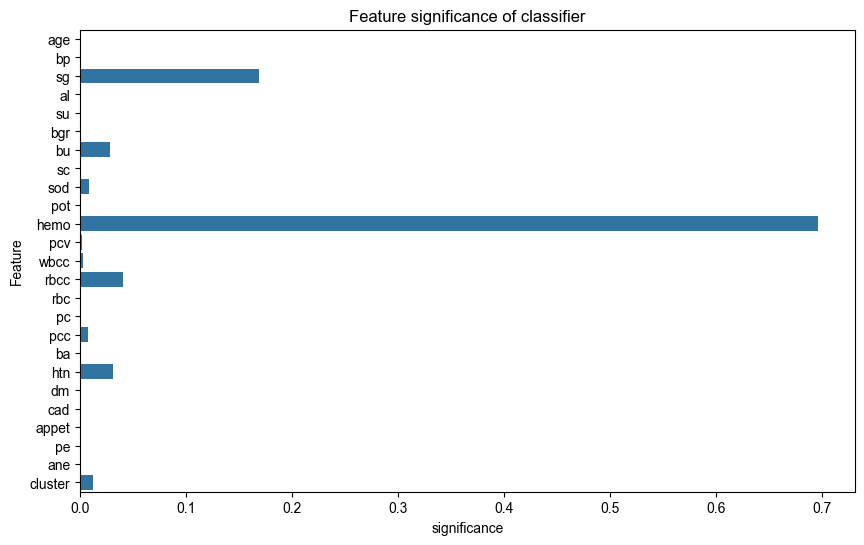

In [113]:
interpretable_classifier = DecisionTreeClassifier()
interpretable_classifier.fit(X, y)
significance = interpretable_classifier.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=significance, y=features)
plt.title('Feature significance of classifier')
plt.xlabel('significance')
plt.ylabel('Feature')
plt.show()

(14)

In [114]:
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning, message='X does not have valid feature names')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

k = 3  
kmeans = KMeans(n_clusters=k, random_state=42)
X_train['cluster'] = kmeans.fit_predict(X_train.drop(columns='cluster', errors='ignore'))
X_test['cluster'] = kmeans.predict(X_test.drop(columns='cluster', errors='ignore'))

classifiers = {
    cluster_id: RandomForestClassifier(random_state=42)
    for cluster_id in range(k)
}

feature_names = [col for col in X_train.columns if col != 'cluster']
for cluster_id, model in classifiers.items():
     cluster_mask = (X_train['cluster'] == cluster_id)
     X_train_cluster = X_train.loc[cluster_mask, feature_names]
     y_train_cluster = y_train[cluster_mask]
     model.fit(X_train_cluster, y_train_cluster)

test_predictions = []
for index, row in X_test.iterrows():
     cluster_id = row['cluster']
     model = classifiers[cluster_id]
     formatted_row = row[feature_names].values.reshape(1, -1)
     prediction = model.predict(formatted_row)
     test_predictions.append(prediction[0])

rf_accuracy_clustered = accuracy_score(y_test, test_predictions)
rf_f1_clustered = f1_score(y_test, test_predictions, average='weighted')

print(f"Random Forest Classifier Improved by Subclustering - Accuracy: {rf_accuracy_clustered}")
print(f"Random forest classifier improved by subclustering - F1 score: {rf_f1_clustered}")
print("Original Random Forest Classifier - Accuracy:", rf_accuracy)
print("Original random forest classifier - F1 score:", rf_f1)

Random Forest Classifier Improved by Subclustering - Accuracy: 0.9916666666666667
Random forest classifier improved by subclustering - F1 score: 0.9916779447728946
Original Random Forest Classifier - Accuracy: 1.0
Original random forest classifier - F1 score: 1.0


(15)

I completed individually.